<a href="https://colab.research.google.com/github/kelvin-kiplagat/DTE-Team-5/blob/main/DTE_Team_5_Phase_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce

# ML
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from sklearn.model_selection import train_test_split

nltk.download('punkt')
plt.style.use("seaborn-v0_8-bright")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Mount Drive**

In [2]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


**Datasets**
- Full paths to the datasets

In [3]:
access_path = './drive/MyDrive/Datathon/Phase II/Data'

In [4]:
# Read in the dataframes
cancer_df, covid_df, heart_df, hiv_df, malaria_df, pneumonia_df = [pd.read_csv(access_path + f"/{fname}") for fname in os.listdir(access_path)]

datasets = [cancer_df, covid_df, heart_df, hiv_df, malaria_df, pneumonia_df]
study_areas = ["cancer", "covid", "heart", "HIV", "malaria", "pneumonia"]
cols_to_drop = ['nct_number', 'study_title', 'study_url', 'acronym', 'brief_summary', 'other_ids', 'study_documents'] #'secondary_outcome_measures', 'primary_outcome_measures'


# process the column names, drop unnecessary columns, and merge the dataframes into one big dataframe
clinical_df = pd.DataFrame()
for i in range(len(datasets)):
    df = datasets[i]
    disease_of_interest = study_areas[i]
    df.columns = [col.lower().replace(" ","_") for col in df.columns]
    df_ = df.drop(columns = cols_to_drop)
    df_['study_area'] = disease_of_interest
    clinical_df = pd.concat([clinical_df, df_], axis = 0, ignore_index = True)

# Drop rows that do not have a start date
print(f"Number of trials with no start date: {clinical_df.start_date.isna().sum()}")
clinical_df = clinical_df.loc[clinical_df.start_date.notna(), :]
# Preprocess date columns
date_columns = ["start_date", "primary_completion_date", "completion_date", "first_posted", "results_first_posted", "last_update_posted"]
clinical_df[date_columns] = reduce(lambda x, y : pd.concat([x, y], axis = 1), [pd.to_datetime(clinical_df[col], format = "%Y-%m-%d", errors = "coerce") for col in date_columns])
clinical_df['start_year'] = clinical_df.start_date.apply(lambda x : x.year)
clinical_df = clinical_df.loc[clinical_df.start_year < 2024, :] # Filter out any clinical trial that has not started
clinical_df['days_to_completion'] = (clinical_df.completion_date - clinical_df.start_date).apply(lambda x : x.days) # Compute days to completion

# Extract the Masking Type and Intervention Model
def extract_model(text):
    if type(text) != float: # Unpopular way of eliminating NaNs
        if "Intervention" in text:
            texts = text.split("|")
            intervention_model = texts[1].split(": ")[1]
            return (intervention_model)
        return np.nan
    return np.nan

def extract_masking(text):
    if type(text) != float: # Unpopular way of eliminating NaNs
        if "Intervention" in text:
            texts = text.split("|")
            masking = texts[2].split(" ")[1]
            return (masking)
        return np.nan
    return np.nan

# Add those columns
clinical_df["intervention_model"] = clinical_df.study_design.apply(extract_model)
clinical_df["masking"] = clinical_df.study_design.apply(extract_masking)
clinical_df["has_collaborators"] =  clinical_df.collaborators.apply(lambda x: 0 if pd.isnull(x)  else 1) # 0 if no collaborators else 1
clinical_df["interventions_count"] = clinical_df.interventions.apply(lambda x: 0 if pd.isnull(x)  else len(x.split("|")))
clinical_df["all_outcome_measures"] = (clinical_df["primary_outcome_measures"].replace(np.nan, "") + " " + # Merge all the outcome measures into 1
                                       clinical_df["secondary_outcome_measures"].replace(np.nan, "") + " " +
                                       clinical_df["other_outcome_measures"].replace(np.nan, ""))
clinical_df = clinical_df.drop(columns = ['secondary_outcome_measures', 'primary_outcome_measures', 'other_outcome_measures'])

print("Total Number of Observations: ",clinical_df.shape[0])
print(clinical_df.info())
clinical_df.sample(5)

Number of trials with no start date: 2356
Total Number of Observations:  159008
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159008 entries, 0 to 161862
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   study_status             159008 non-null  object        
 1   study_results            159008 non-null  object        
 2   conditions               159006 non-null  object        
 3   interventions            141952 non-null  object        
 4   sponsor                  159008 non-null  object        
 5   collaborators            60055 non-null   object        
 6   sex                      158872 non-null  object        
 7   age                      159008 non-null  object        
 8   phases                   79909 non-null   object        
 9   enrollment               156568 non-null  float64       
 10  funder_type              159008 non-null  object        
 11

,study_status,study_results,conditions,interventions,sponsor,collaborators,sex,age,phases,enrollment,...,last_update_posted,locations,study_area,start_year,days_to_completion,intervention_model,masking,has_collaborators,interventions_count,all_outcome_measures
51006,RECRUITING,NO,Breast Cancer Patients Undergoing Mastectomy W...,DRUG: Morphine|OTHER: Ultrasound-guided erecto...,The Netherlands Cancer Institute,NaN,FEMALE,"ADULT, OLDER_ADULT",NaN,100.0,...,2022-10-21,"NKI-AvL, Amsterdam, Noord-Holland, 1066CX, Net...",cancer,2021,578.0,PARALLEL,TRIPLE,0,2,Mean difference of highest numerical rating sc...
34895,RECRUITING,NO,"Solid Tumor, Adult",BIOLOGICAL: GEN1053,Genmab,BioNTech SE,ALL,"ADULT, OLDER_ADULT",PHASE1|PHASE2,103.0,...,2023-08-08,"Yale University, New Haven, Connecticut, 06510...",cancer,2022,1731.0,SINGLE_GROUP,NONE,1,1,"Escalation: Dose Limiting Toxicities (DLTs), T..."
158445,UNKNOWN,NO,Senile Cataract,OTHER: Questionnaire,Medical University Innsbruck,NaN,ALL,"ADULT, OLDER_ADULT",NaN,116.0,...,2020-09-23,"Medical University Innsbruck, Innsbruck, Tyrol...",pneumonia,2020,174.0,NaN,NaN,0,1,"Improvement Vision-related quality of life, Ex..."
128796,UNKNOWN,NO,Congestive Heart Failure,RADIATION: Echocardiography,Assiut University,NaN,ALL,"ADULT, OLDER_ADULT",NaN,289.0,...,2020-06-22,NaN,heart,2020,518.0,NaN,NaN,0,1,"risk factors of CHF in hemodialysis patients, ..."
85911,UNKNOWN,NO,HIV-associated Hodgkin Lymphoma,DRUG: Doxorubicin|DRUG: Bleomycin|DRUG: Vinbla...,Harlachinger Krebshilfe e.V.,Deutsche AIDS Gesellschaft e.V.,ALL,"ADULT, OLDER_ADULT",PHASE2,130.0,...,2011-11-09,"Vivantes Auguste Victoria Klinikum, Berlin, 12...",cancer,2004,3044.0,SINGLE_GROUP,NONE,1,9,Number of patients with World Health Organizat...


## **Clinical Trials with No Enrollment Data**

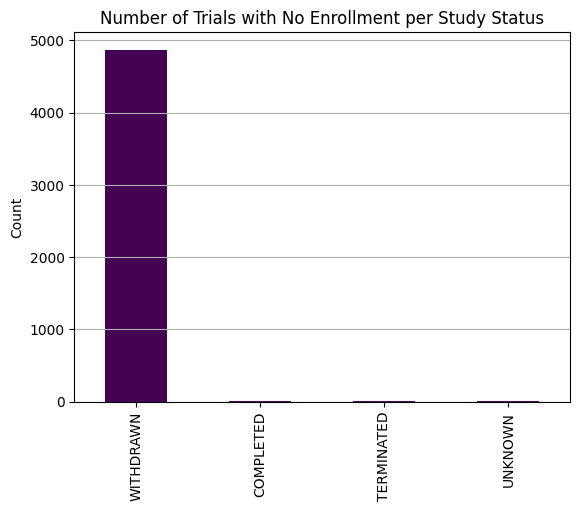


Complete Clinical Trials Data with No Enrollment


,sponsor,study_results,study_area,start_date,completion_date,funder_type
110182,ViiV Healthcare,NO,heart,2009-03-01,2010-12-01,INDUSTRY
128145,"National Heart, Lung, and Blood Institute (NHLBI)",NO,heart,2007-01-11,2007-12-10,NIH
141951,ViiV Healthcare,NO,HIV,2009-03-01,2010-12-01,INDUSTRY
144401,National Institute of Allergy and Infectious D...,NO,HIV,2006-02-16,2007-11-15,NIH
147761,National Institute of Environmental Health Sci...,NO,HIV,2004-06-25,2007-12-28,NIH
151090,National Institute of Allergy and Infectious D...,NO,malaria,2004-06-09,2008-02-06,NIH
152129,National Institute of Allergy and Infectious D...,NO,malaria,2005-03-07,2008-06-17,NIH
152153,National Institute of Allergy and Infectious D...,NO,malaria,2005-03-08,2008-07-02,NIH
156975,National Institutes of Health Clinical Center ...,NO,pneumonia,2006-08-11,2007-05-22,NIH


In [5]:
no_enroll = clinical_df[clinical_df.enrollment == 0]
# Bar Plot per Study Status
no_enroll.study_status.value_counts().plot(kind = "bar", cmap = "viridis")
plt.title("Number of Trials with No Enrollment per Study Status")
plt.ylabel("Count")
plt.grid(axis = "y")
plt.show()

# Interested in the "COMPLETED" with no enrollment
print("\n================================================\nComplete Clinical Trials Data with No Enrollment\n================================================")
no_enroll.loc[no_enroll.study_status == "COMPLETED", ["sponsor", "study_results", "study_area", "start_date", "completion_date", "funder_type"]]

### Enrollment Numbers Over Time
- Eliminating Observations with no Enrollment Data

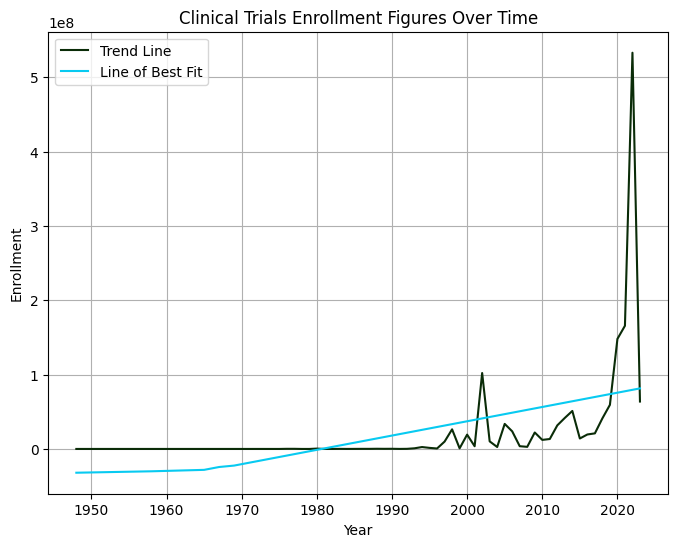

In [17]:
# Eliminating Observations with no Enrollment Data
clinical_df = clinical_df.loc[clinical_df.enrollment != 0, :]

# Clinical enrollment data over time
enrollment_over_time = clinical_df.groupby('start_year').enrollment.sum()
t = np.arange(1, enrollment_over_time.shape[0]+1, 1)
a, b = np.polyfit(t, enrollment_over_time.tolist(), 1)
lbf = a*t + b # Line of best fit
enrollment_over_time.plot(kind = 'line', figsize = (8, 6), color = '#0A2C08', label = "Trend Line")
plt.plot(enrollment_over_time.index, lbf, label = "Line of Best Fit", color = "#08CAF1")
plt.title("Clinical Trials Enrollment Figures Over Time")
plt.xlabel("Year")
plt.ylabel("Enrollment")
plt.legend()
plt.grid()
plt.show()


## **Descriptive Statistics of the Numeric Data**

In [7]:
clinical_df._get_numeric_data().drop(columns = ['start_year', 'has_collaborators']).describe()

,enrollment,days_to_completion,interventions_count
count,1.516770e+05,148856.000000,154117.000000
mean,9.784273e+03,1406.555725,1.797180
std,7.857562e+05,1378.653167,1.702755
min,1.000000e+00,0.000000,0.000000
25%,3.300000e+01,549.000000,1.000000
50%,8.000000e+01,1078.000000,1.000000
75%,2.480000e+02,1826.000000,2.000000
max,1.888141e+08,40177.000000,57.000000


### **Insights - Anomalies**

- The mean enrollment is way greater than the 75th Percentile. The data is heavily right skewed.
- Maximum days taken by clinical study is 40177days (roughly 110 years)
- For any analysis, we will have to omit those outliers but before, ommision, let's find out what about them

#### **Outlier Clinical Trials in Terms of Enrollment and Days to Completion**

Number of Clinical Trials Taking longer than usual: 2363


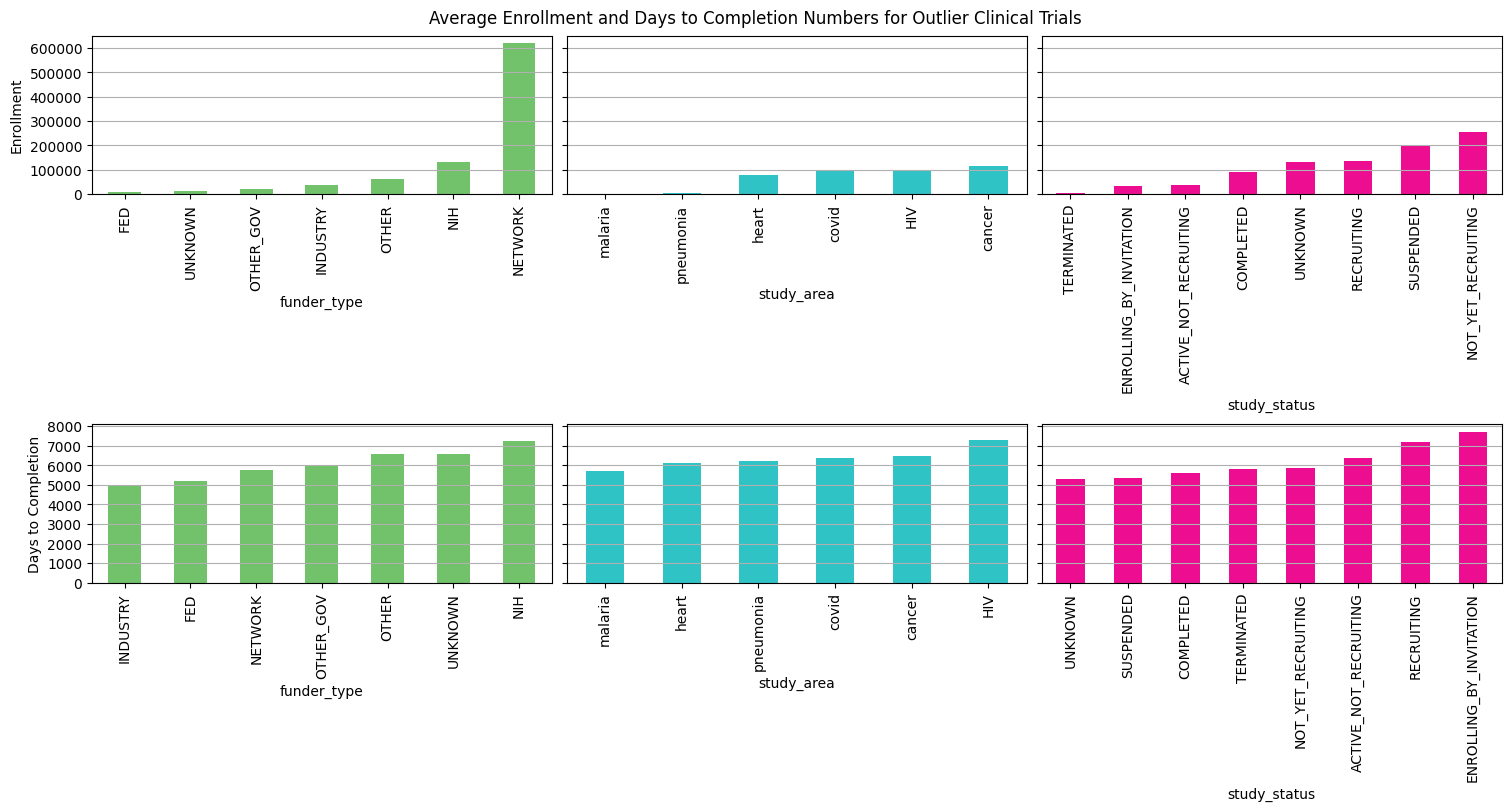

In [8]:
# Investigate trials whose days to completion are beyond outlier range
Q3_dtc, Q3_enrl = clinical_df.days_to_completion.quantile(0.75), clinical_df.enrollment.quantile(0.75)
IQR_dtc = Q3_dtc - clinical_df.days_to_completion.quantile(0.25)
IQR_enrl = Q3_enrl - clinical_df.enrollment.quantile(0.25)

outlier_trials = clinical_df.loc[
    (clinical_df.days_to_completion >= Q3_dtc + 1.5*IQR_dtc) & (clinical_df.enrollment >= Q3_enrl + 1.5*IQR_enrl ),
    ["sponsor", "funder_type", "study_area", "study_status", "enrollment", "start_date", "completion_date", "days_to_completion"]
]
print("Number of Clinical Trials Taking longer than usual:",outlier_trials.shape[0])

funder_group = outlier_trials.groupby("funder_type")
study_area_group = outlier_trials.groupby("study_area")
study_status_group = outlier_trials.groupby("study_status")

# Visualize a few things to get the overall idea
fig, ax = plt.subplots(nrows = 2, ncols = 3, constrained_layout = True, figsize = (15, 8), sharey = 'row')
# Funder group
funder_group["enrollment"].mean().sort_values().plot(kind = "bar", ax =  ax[0,0], color = "#71C26A")
funder_group["days_to_completion"].mean().sort_values().plot(kind = "bar", ax =  ax[1,0], color = "#71C26A")
# Study area
study_area_group["enrollment"].mean().sort_values().plot(kind = "bar", ax =  ax[0,1], color = "#2FC3C6")
study_area_group["days_to_completion"].mean().sort_values().plot(kind = "bar", ax =  ax[1,1], color = "#2FC3C6")
# Study status
study_status_group["enrollment"].mean().sort_values().plot(kind = "bar", ax =  ax[0,2], color = "#EC0D91")
study_status_group["days_to_completion"].mean().sort_values().plot(kind = "bar", ax =  ax[1,2], color = "#EC0D91")
ax[0,0].set_ylabel("Enrollment")
ax[0,0].set_yticks(range(0, 600001, 100000), range(0, 600001, 100000))
ax[1,0].set_ylabel("Days to Completion")
ax[1,0].set_yticks(range(0, 8001, 1000), range(0, 8001, 1000))
for a_x in ax.flat:
    a_x.grid(True, axis = "y")
fig.suptitle("Average Enrollment and Days to Completion Numbers for Outlier Clinical Trials", fontweight = 20)
plt.show()

#### **Normal Data - Clinical Trials Inside the Outlier Upper Threshold**

In [9]:
clinical_trials = clinical_df.loc[
    ~((clinical_df.days_to_completion >= Q3_dtc + 1.5*IQR_dtc) & (clinical_df.enrollment >= Q3_enrl + 1.5*IQR_enrl )) # Negate the boolean filter used above
]
clinical_trials.shape

(151754, 28)

#### Average Number of Days Taken by Each Study Area Clinical Trials

<Axes: xlabel='study_area'>

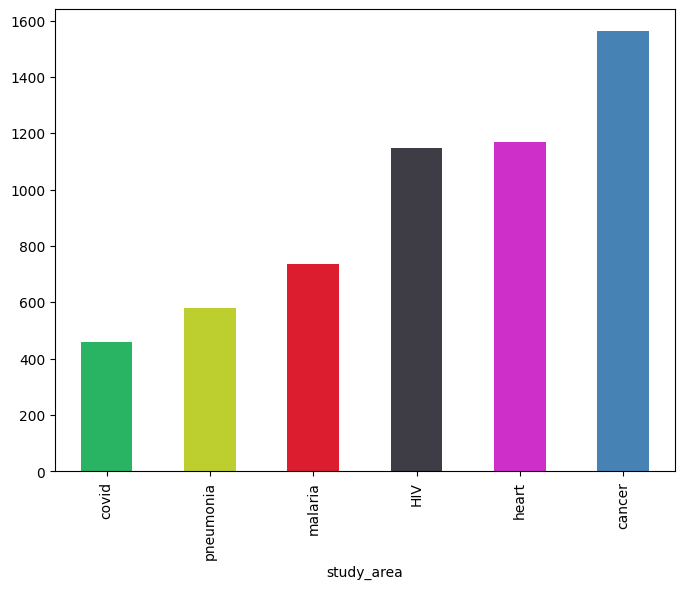

In [10]:
clinical_trials.groupby('study_area')['days_to_completion'].mean().sort_values().plot(
    kind = 'bar', figsize = (8,6), color = ["#28B463", "#BDCE2F", "#DB1D2F", "#3E3C45", "#CE2FC9", "steelblue"])

Text(0.5, 1.0, 'Days to Completion by Gender')

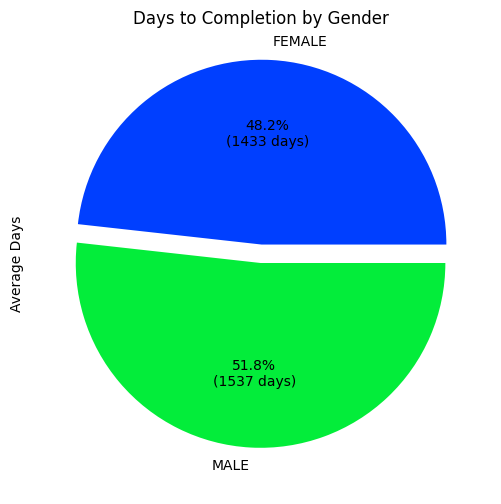

In [11]:
data_trials = clinical_trials.loc[clinical_trials.sex != 'ALL'].groupby('sex').days_to_completion.mean()
def func(pct, data):
    ab = int(np.round(pct/100.*np.sum(data)))
    return f"{pct:.1f}%\n({ab:d} days)"
data_trials.plot(
    kind = "pie", explode = [0.1, 0], figsize = (6,6), label = "Average Days", autopct = lambda x: func(x, data_trials)
)
plt.title("Days to Completion by Gender")

In [13]:
clinical_trials.columns

Index(['study_status', 'study_results', 'conditions', 'interventions',
       'sponsor', 'collaborators', 'sex', 'age', 'phases', 'enrollment',
       'funder_type', 'study_type', 'study_design', 'start_date',
       'primary_completion_date', 'completion_date', 'first_posted',
       'results_first_posted', 'last_update_posted', 'locations', 'study_area',
       'start_year', 'days_to_completion', 'intervention_model', 'masking',
       'has_collaborators', 'interventions_count', 'all_outcome_measures'],
      dtype='object')

### Features of Interest
1. study status
2. study results
3. sex
4. age
5. phases
6. enrollment
7. study area (disease)
8. start year
9. days to completion
10. intervention model
11. Masking
12. has collaborator
13. Inteventions count

### Questions
1. Are their differences in the number of collaborators different study areas get?
2. Does the number of interventions differ in different study areas?
3. Does availability of collaborators affect study status in completed and terminated, and suspended studies?
4. Does the Funder type affect the study status

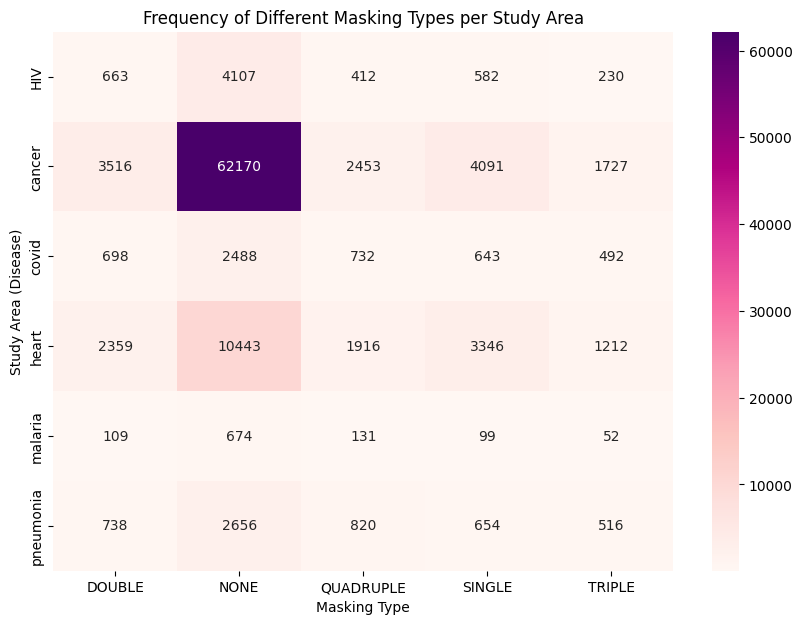

In [35]:
# Frequency of masking types under different study areas
masking_study_area = clinical_trials.loc[clinical_trials.masking != ''].groupby(
    ['masking', 'study_area']
    )['masking'].count().to_frame().rename(
        columns = {'masking' : 'frequency'}
        ).reset_index().pivot(
            index = 'study_area', columns = 'masking', values = 'frequency')
fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(masking_study_area, annot = True, ax = ax, cmap = "RdPu", fmt = "g")
plt.title("Frequency of Different Masking Types per Study Area")
plt.xlabel("Masking Type"), plt.ylabel("Study Area (Disease)")
plt.show()

In [12]:
clinical_trials.head(6)

,study_status,study_results,conditions,interventions,sponsor,collaborators,sex,age,phases,enrollment,...,last_update_posted,locations,study_area,start_year,days_to_completion,intervention_model,masking,has_collaborators,interventions_count,all_outcome_measures
0,COMPLETED,YES,Urothelial Carcinoma,DRUG: Ramucirumab|DRUG: Docetaxel|DRUG: Placebo,Eli Lilly and Company,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,530.0,...,2023-08-21,"Highlands Oncology Group, Fayetteville, Arkans...",cancer,2015,2570.0,PARALLEL,DOUBLE,0,3,"Progression Free Survival (PFS), PFS defined a..."
1,NOT_YET_RECRUITING,NO,Prostate Carcinoma,DRUG: Fluorine F 18 DCFPyL|DRUG: Gadobenate Di...,Northwestern University,National Cancer Institute (NCI),MALE,"ADULT, OLDER_ADULT",PHASE2,106.0,...,2022-08-03,"Northwestern University, Chicago, Illinois, 60...",cancer,2023,1841.0,SINGLE_GROUP,NONE,1,7,18-F-DCFPyL positron emission tomography (PET)...
2,NOT_YET_RECRUITING,NO,Breast Neoplasm Female|Lymphatic Metastasis,PROCEDURE: Radiotherapy,Kyungpook National University Chilgok Hospital,Korean Breast Cancer Study Group,FEMALE,"ADULT, OLDER_ADULT",NaN,1380.0,...,2019-10-04,NaN,cancer,2020,1825.0,SINGLE_GROUP,NONE,1,1,"Disease-free survival, Disease free survival i..."
3,COMPLETED,NO,Pioglitazone,DRUG: Pioglitazone|DRUG: Metformin|DRUG: Clomi...,Ain Shams University,NaN,FEMALE,ADULT,EARLY_PHASE1,400.0,...,2021-06-02,"Ain Shams Univerisity, Cairo, Egypt",cancer,2018,1155.0,SINGLE_GROUP,SINGLE,0,3,"Clinical pregnancy rate, Pregnancy rate diagno..."
4,UNKNOWN,NO,First Line WT KRAS mCRC,NaN,Dr.Laurent Mineur,"Merck Serono International SA|BESPIM, CHU Nîme...",ALL,"ADULT, OLDER_ADULT",NaN,500.0,...,2012-12-27,"Institut Sainte-Catherine, Avignon, Vaucluse, ...",cancer,2010,1247.0,NaN,NaN,1,0,To compare PFS rate at 1 year with PFS in clin...
5,COMPLETED,YES,Bladder Cancer|Low Testosterone Levels,NaN,University of Kansas Medical Center,NaN,MALE,"ADULT, OLDER_ADULT",NaN,25.0,...,2021-08-03,"University of Kansas Medical Center, Kansas Ci...",cancer,2017,385.0,NaN,NaN,0,0,Number of Hypogonadism in Participants Based o...


In [11]:
# Topic Modelling
clinical_complete = clinical_df.loc[(clinical_df.study_status == "COMPLETED") & (clinical_df.study_results == "YES")]
clinical_complete.sample(5)

train, test = train_test_split(clinical_complete, test_size = 0.3, random_state = 107)

def tokenizer(text):
    tokens = [word for word in nltk.word_tokenize(text) if len(word) > 3]
    return tokens

vectorizer = TfidfVectorizer(tokenizer = tokenizer,
                             stop_words = "english",
                             max_df = 0.8,
                             max_features = 10000,
                             use_idf = True,
                             norm = None)
train_vectors = vectorizer.fit_transform(train.all_outcome_measures)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
lda = LatentDirichletAllocation(n_components = 2,
                                max_iter = 3,
                                learning_method = "online",
                                learning_offset = 50,
                                n_jobs = -1,
                                random_state = 107)
weights = lda.fit_transform(train_vectors)
H = lda.components_

In [13]:
np.set_printoptions(suppress = True)
weights

array([[0.31817381, 0.68182619],
       [0.82190548, 0.17809452],
       [0.95225027, 0.04774973],
       ...,
       [0.36473117, 0.63526883],
       [0.01939525, 0.98060475],
       [0.44369335, 0.55630665]])

In [14]:
np.argmax(weights, axis = 1)

array([1, 0, 0, ..., 1, 1, 1])

In [15]:
weights[:20]

array([[0.31817381, 0.68182619],
       [0.82190548, 0.17809452],
       [0.95225027, 0.04774973],
       [0.02303901, 0.97696099],
       [0.99442964, 0.00557036],
       [0.00526826, 0.99473174],
       [0.74328942, 0.25671058],
       [0.21848674, 0.78151326],
       [0.00127262, 0.99872738],
       [0.99973958, 0.00026042],
       [0.00045051, 0.99954949],
       [0.10824625, 0.89175375],
       [0.15915452, 0.84084548],
       [0.77332634, 0.22667366],
       [0.89463673, 0.10536327],
       [0.91540893, 0.08459107],
       [0.99690931, 0.00309069],
       [0.83005221, 0.16994779],
       [0.06404194, 0.93595806],
       [0.47660675, 0.52339325]])

In [16]:
print(*train.all_outcome_measures[:20].tolist(), sep = "\n---=>")

Overall Response Rate (ORR), ORR was defined as the percentage of participants with a confirmed Complete Response (CR) or Partial Response (PR) by investigator assessment as per RECIST v1 .1 criteria. Specifically, ORR = (number of subjects with a confirmed best overall response of CR or PR) divided by the total number of subjects in the corresponding analysis population., From study treatment start date until first documented complete response or partial response, assessed up to approximately 50 months Progression Free Survival (PFS) Based on Local Investigator Assessment, Progression Free Survival (PFS) was defined as the time from study treatment start date to the date of first radiologically documented progression or death due to any cause. If a patient did not progress or die at the time of the analysis data cut-off or start of new antineoplastic therapy, PFS was censored at the date of the last adequate tumor assessment before the earliest of the cut-off date or the start date of